- 순환신경망 종류
    * 심플 순환신경망(Simple RNN) 단점
        - 긴 문장(단어의 갯수가 많은 경우)을 학습하기 어려움
        - 문장이 길 수록(단어의 갯수가 많을 수록) 초반의 정보(단어를 의미함)는 점진적으로 희석(소멸)됨
        - 즉, 멀리 떨어져 있는 단어의 정보를 인식하는데 어려움이 있음
            - 문장의 앞뒤 문맥(단어를 의미함) 데이터의 기억이 단기기억으로 저장됨
    - 이러한 단점을 보완한 모델이 LSTM 임
 
    * 장기기억 순환신경망(Long Shot-Term Memory, LSTM)
        - Simple RNN의 단점을 보완한 모델
        - 단기기억을 오래 기억할 수 있도록 고안된 모델
        - 많은 이전 단어들의 정보를 기억해야 하기 때문에 훈련 속도가 느림(단점)
        - 시스템 저장 공간이 많이 필요함(단점)
 
    * 게이트웨이 반복 단위 순환신경망(Gated Recurrent Unit, GRU)
        - LSTM의 장기기억 순환신경망의 개념을 그대로 적용하고, 단점을 보완한 모델
        - 너무 오래된 기억은 서서히 소멸해 나가면서, 최근 기억을 지속적으로 유지하는 방식을 사용함
        - 성능은 LSTM과 동일 (속도를 빠르게 하기 위한 모델임)
 
    * RNN 순환신경망 모델들은 주로, RMSprop 옵티마이저를 사용함

### 라이브러리 정의

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
tf.keras.utils.set_random_seed(42)

### 사용할 데이터셋
# - 영화 리뷰 감상평 데이터(긍정/부정)
from tensorflow.keras.datasets import imdb

### 텍스트 길이 정규화 라이브러리
# - 텍스트의 길이가 긴경우 자르고, 길이가 작은 경우에는 채움
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 데이터 읽어 들이기

In [2]:
### 데이터 수집
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

print(train_input.shape, train_target.shape)
print(test_input.shape, test_target.shape)

(25000,) (25000,)
(25000,) (25000,)


### 훈련 : 검증 = 8 : 2로 분리하기

In [3]:
### 변수명 : train_input, train_target, val_input, val_target
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

In [4]:
print(train_input.shape, train_target.shape)
print(val_input.shape, val_target.shape)
print(test_input.shape, test_target.shape)

(20000,) (20000,)
(5000,) (5000,)
(25000,) (25000,)


### 데이터 스케일링하기(단어 길이 표준화하기)

- 제거 및 채우기 속성
- truncating : maxlen보다 클 때 자르기 속성
    - truncating="pre" : 앞쪽 제거(기본값으로 사용됨, 생략가능)
    - truncating="post" : 뒤쪽 제거
* padding : maxlen보다 작을 때 채우기 속성
    - padding="pre" : 앞쪽을 0으로 채우기 (기본값으로 사용됨, 생략가능)
    - padding="post": 뒤쪽을 0으로 채우기

In [5]:
### 텍스트 제거 또는 채우기 속성 추가
### 훈련 데이터 스케일링
train_seq = pad_sequences(train_input, maxlen=100, truncating="post", padding="post")
print(train_seq.shape)

### 검증 데이터 스케일링
val_seq = pad_sequences(val_input, maxlen=100, truncating="post", padding="post")
print(val_seq.shape)

(20000, 100)
(5000, 100)


### LSTM 훈련모델 생성하기

In [6]:
### 모델 생성하기
model = keras.Sequential()
model

In [7]:
### 입력계층 (임베딩 계층) 추가하기
model.add(
    keras.layers.Embedding(input_dim=500, output_dim=16, input_length=100)
)
### 은닉계층 (LSTM 계층) 추가하기 : RNN 모델의 이름만 바꿔주면 됨
model.add(
    keras.layers.LSTM(units=8)
)

### 출력계층 추가하기
model.add(
    keras.layers.Dense(units=1, activation="sigmoid")
)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


- Param 계산공식
    * embedding = 말뭉치갯수 * 출력갯수 = 500 * 16 = 8,000
 
    * LSTM = 가중치 세트 갯수 * (출력갯수 * (입력갯수 + 출력갯수 + 1))
        -  = 4 * (8 * (16 + 8 + 1)) = 800
        
- 가중치 세트 설명
    - 총 4개의 세트로 구성되어 있음(이때 세트를 -> 게이트라고 칭함)
  
* 셀상태관리
    - LSTM의 장기 기억을 담당
    - 셀 상태는 정보를 장기간 동안 유지할 수 있도록 관리됨
    - 입력/망각/출력 게이트를 통해서 셀 상태 정보가 업데이트
 
* 입력게이트
    - 현재 시점의 입력 데이터(단어를 의미함)가 셀 상태에 얼마나 반영될지를 결정
    - 새로운 정보를 얼마나 저장할지를 조절하는 역할을 수행
 
* 망각게이트
    - 이전 셀 상태에서 얼마나 많은 정보를 잊어버릴지 결정
    - 이전 상태의 정보를 얼마나 제거할지를 조절하는 역할
 
* 출력게이트
    - 셀 상태에서 어떤 정보를 출력할지 결정
    - 셀 상태를  현재 시점의 출력으로 변환하는 역할
 
* 가중치 업데이트 : 위 4개의 가중치 세트가 동시에 작동하면서 출력에 가장 가까운 단어 조합을 만들어 냄


### 훈련모델 설정하기(compile)

In [9]:
### rmsprop 사용, 학습율 0.0001 사용, 정확도 출력
rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=rmsprop,
              loss="binary_crossentropy",
              metrics="accuracy")

### 콜백함수 정의하기

In [10]:
### 콜백함수 정의
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "./model/best_LSTM_model.h5", save_best_only=True
)
earlystopping_cb = keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True
)

### 모델 훈련시키기

In [11]:
history = model.fit(
    train_seq, train_target, epochs=100, batch_size=64,
    validation_data=(val_seq, val_target),
    callbacks=[checkpoint_cb, earlystopping_cb]
)

Epoch 1/100
313/313 [==============================] - 5s 9ms/step - loss: 0.6931 - accuracy: 0.5045 - val_loss: 0.6930 - val_accuracy: 0.5122
Epoch 2/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6928 - accuracy: 0.5372 - val_loss: 0.6927 - val_accuracy: 0.5350
Epoch 3/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6923 - accuracy: 0.5594 - val_loss: 0.6921 - val_accuracy: 0.5450
Epoch 4/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6914 - accuracy: 0.5685 - val_loss: 0.6907 - val_accuracy: 0.5820
Epoch 5/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6891 - accuracy: 0.5972 - val_loss: 0.6865 - val_accuracy: 0.6212
Epoch 6/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6754 - accuracy: 0.6291 - val_loss: 0.6531 - val_accuracy: 0.6666
Epoch 7/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6390 - accuracy: 0.6883 - val_loss: 0.6261 - val_accuracy: 0.6976

### 최적의 모델 읽어들여서 훈련/검증/테스트 성능 검증하기

In [12]:
### 최적의 모델
best_model = keras.models.load_model("./model/best_LSTM_model.h5")

train_score = best_model.evaluate(train_seq, train_target)
val_score   = best_model.evaluate(val_seq, val_target)

### 테스트 데이터는 -> 스케일링 처리 후 성능검증하기...
test_seq = pad_sequences(test_input, maxlen=100, truncating="post", padding="post")
test_score  = best_model.evaluate(test_seq, test_target)

782/782 [==============================] - 3s 4ms/step - loss: 0.4794 - accuracy: 0.7671


### LSTM 계층 자체에 Dropout 속성 적용

In [13]:
### RNN 계층은 자체적으로 Dropout을 사용할 수 있음
# - 속성명 : dropout(소문자) = 소숫점값(제외할 비율)
# - 사용 방법 : RNN 계층 정의시 속성으로 넣어주면 됨

# 모델명 : model
# 계층구조
# - 입력계층 : 단어임베딩계층 사용, 출력크기는 16
# - LSTM계층 : 출력크기는 8, 드랍아웃 속성 적용(30% 제외)
# - 출력계층
# 모델 환경설정 : rmsprop 사용, 학습율(0.0001 사용)
# 콜백함수 정의 : 저장 모델 파일명 : best_LSTM_model_dropout.h5
# 훈련시키기 : 반복횟수 100회, 배치사이즈 64

In [14]:
### 모델 생성하기
model = keras.Sequential()

### 입력계층 (임베딩 계층) 추가하기
model.add(
    keras.layers.Embedding(input_dim=500, output_dim=16, input_length=100)
)
### 은닉계층 (LSTM 계층) 추가하기 : RNN 모델의 이름만 바꿔주면 됨
model.add(
    keras.layers.LSTM(units=8, dropout=0.2)
)

### 출력계층 추가하기
model.add(
    keras.layers.Dense(units=1, activation="sigmoid")
)

### rmsprop 사용, 학습율 0.0001 사용, 정확도 출력
rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(
    optimizer=rmsprop,
    loss="binary_crossentropy",
    metrics="accuracy"
)

### 콜백함수 정의
mcp_cb = keras.callbacks.ModelCheckpoint(
    "./model/best_LSTM_model_dropout.h5",
    save_best_only=True
)

es_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

### 모델 훈련시키기
history = model.fit(
    train_seq, train_target, epochs=100, batch_size=64,
    validation_data=(val_seq, val_target),
    callbacks=[mcp_cb, es_cb]
)

Epoch 1/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6927 - accuracy: 0.5179 - val_loss: 0.6915 - val_accuracy: 0.5514
Epoch 2/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6906 - accuracy: 0.5577 - val_loss: 0.6891 - val_accuracy: 0.5686
Epoch 3/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6862 - accuracy: 0.5784 - val_loss: 0.6808 - val_accuracy: 0.5898
Epoch 4/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6542 - accuracy: 0.6350 - val_loss: 0.6157 - val_accuracy: 0.6856
Epoch 5/100
313/313 [==============================] - 2s 7ms/step - loss: 0.5946 - accuracy: 0.7009 - val_loss: 0.5798 - val_accuracy: 0.7196
Epoch 6/100
313/313 [==============================] - 2s 7ms/step - loss: 0.5680 - accuracy: 0.7265 - val_loss: 0.5616 - val_accuracy: 0.7298
Epoch 7/100
313/313 [==============================] - 2s 7ms/step - loss: 0.5537 - accuracy: 0.7356 - val_loss: 0.5498 - val_accuracy: 0.7384

In [15]:
### 최적의 모델 읽어들여서, 훈련/검증/테스트 데이터로 성능검증
best_model = keras.models.load_model("./model/best_LSTM_model_dropout.h5")

best_model.evaluate(train_seq, train_target)
best_model.evaluate(val_seq, val_target)
best_model.evaluate(test_seq, test_target)

782/782 [==============================] - 3s 3ms/step - loss: 0.4702 - accuracy: 0.7744


[0.47016382217407227, 0.774399995803833]

#### 성능향상 - LSTM 계층을 연속하여 사용하기

In [16]:
### 모델 생성하기
model = keras.Sequential()

### 입력계층 (임베딩 계층) 추가하기
model.add(
    keras.layers.Embedding(input_dim=500, output_dim=16, input_length=100)
)

### 은닉계층 (LSTM 계층) 추가하기 : RNN 모델의 이름만 바꿔주면 됨
model.add(
    ## return_sequences= : 단어 단위 훈련 결과의 시퀀스를 다음 LSTM으로 넘겨서 계속 훈련
    ##                   : LSTM 계층을 연속하여 사용할 경우 사용
    keras.layers.LSTM(units=8, dropout=0.3, return_sequences=True)
)

### 은닉계층 추가!!! 
model.add(
    keras.layers.LSTM(units=8)
)

### 출력계층 추가하기
model.add(
    keras.layers.Dense(units=1, activation="sigmoid")
)

### rmsprop 사용, 학습율 0.0001 사용, 정확도 출력
rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=rmsprop,
              loss="binary_crossentropy",
              metrics="accuracy")

### 콜백함수 정의
mcp_cb = keras.callbacks.ModelCheckpoint(
    "./model/best_LSTM_model_dropout.h5",
    save_best_only=True
)
es_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

### 모델 훈련시키기
history = model.fit(
    train_seq, train_target, epochs=100, batch_size=64,
    validation_data=(val_seq, val_target),
    callbacks=[mcp_cb, es_cb]
)

Epoch 1/100
313/313 [==============================] - 5s 13ms/step - loss: 0.6930 - accuracy: 0.5102 - val_loss: 0.6928 - val_accuracy: 0.5134
Epoch 2/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6922 - accuracy: 0.5406 - val_loss: 0.6916 - val_accuracy: 0.5202
Epoch 3/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6894 - accuracy: 0.5624 - val_loss: 0.6865 - val_accuracy: 0.5430
Epoch 4/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6662 - accuracy: 0.5908 - val_loss: 0.6396 - val_accuracy: 0.6466
Epoch 5/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6165 - accuracy: 0.6827 - val_loss: 0.6028 - val_accuracy: 0.7062
Epoch 6/100
313/313 [==============================] - 4s 12ms/step - loss: 0.5877 - accuracy: 0.7090 - val_loss: 0.5794 - val_accuracy: 0.7314
Epoch 7/100
313/313 [==============================] - 4s 12ms/step - loss: 0.5681 - accuracy: 0.7242 - val_loss: 0.5602 - val_accuracy:

In [17]:
### 최적의 모델 읽어들여서, 훈련/검증/테스트 데이터로 성능검증하기
best_model = keras.models.load_model("./model/best_LSTM_model_dropout.h5")

best_model.evaluate(train_seq, train_target)
best_model.evaluate(val_seq, val_target)
best_model.evaluate(test_seq, test_target)

# 625/625 [==============================] - 4s 5ms/step - loss: 0.4683 - accuracy: 0.7871
# 157/157 [==============================] - 1s 6ms/step - loss: 0.4992 - accuracy: 0.7572
# 782/782 [==============================] - 5s 6ms/step - loss: 0.4906 - accuracy: 0.7681

782/782 [==============================] - 4s 5ms/step - loss: 0.4783 - accuracy: 0.7700


[0.47826144099235535, 0.7699999809265137]

In [18]:
### 모델 생성하기
model = keras.Sequential()

### 입력계층 (임베딩 계층) 추가하기
model.add(
    keras.layers.Embedding(input_dim=500, output_dim=16, input_length=100)
)

### 은닉계층 (LSTM 계층) 추가하기 : RNN 모델의 이름만 바꿔주면 됨
model.add(
    keras.layers.LSTM(units=8)
)

### 출력계층 추가하기
model.add(
    keras.layers.Dense(units=1, activation="sigmoid")
)

### rmsprop 사용, 학습율 0.0001 사용, 정확도 출력
rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(
    optimizer=rmsprop,
    loss="binary_crossentropy",
    metrics="accuracy"
)

### 콜백함수 정의
mcp_cb = keras.callbacks.ModelCheckpoint(
    "./model/best_LSTM_model_dropout.h5",
    save_best_only=True
)
es_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

### 모델 훈련시키기
history = model.fit(
    train_seq, train_target, epochs=100, batch_size=64,
    validation_data=(val_seq, val_target),
    # callbacks=[mcp_cb, es_cb]
)

Epoch 1/100
313/313 [==============================] - 4s 8ms/step - loss: 0.6929 - accuracy: 0.5229 - val_loss: 0.6927 - val_accuracy: 0.5310
Epoch 2/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6923 - accuracy: 0.5485 - val_loss: 0.6921 - val_accuracy: 0.5466
Epoch 3/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6914 - accuracy: 0.5650 - val_loss: 0.6910 - val_accuracy: 0.5550
Epoch 4/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6896 - accuracy: 0.5721 - val_loss: 0.6887 - val_accuracy: 0.5676
Epoch 5/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6858 - accuracy: 0.5911 - val_loss: 0.6825 - val_accuracy: 0.5906
Epoch 6/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6673 - accuracy: 0.6245 - val_loss: 0.6398 - val_accuracy: 0.6648
Epoch 7/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6159 - accuracy: 0.6829 - val_loss: 0.6030 - val_accuracy: 0.6960

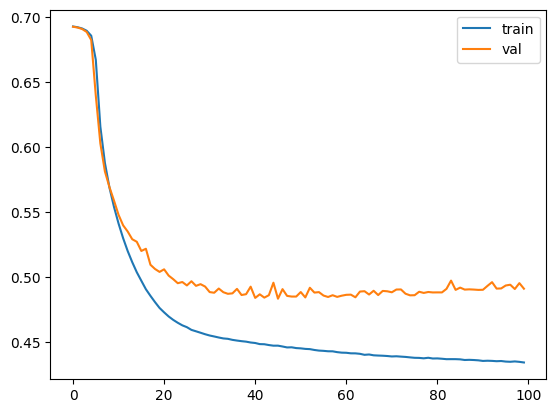

In [19]:
### 손실곡선
plt.plot(history.epoch, history.history["loss"])
plt.plot(history.epoch, history.history["val_loss"])
plt.legend(["train", "val"])
plt.show()

In [20]:
### 모델 생성하기
model = keras.Sequential()

### 입력계층 (임베딩 계층) 추가하기
model.add(
    keras.layers.Embedding(input_dim=500, output_dim=16, input_length=100)
)

### 은닉계층 (LSTM 계층) 추가하기 : RNN 모델의 이름만 바꿔주면 됨
model.add(
    keras.layers.LSTM(units=8)
)

### 출력계층 추가하기
model.add(
    keras.layers.Dense(units=1, activation="sigmoid")
)

### rmsprop 사용, 학습율 0.0001 사용, 정확도 출력
adam = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(
    optimizer=adam,
    loss="binary_crossentropy",
    metrics="accuracy"
)

### 콜백함수 정의
mcp_cb = keras.callbacks.ModelCheckpoint(
    "./model/best_LSTM_model_dropout.h5",
    save_best_only=True
)
es_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

### 모델 훈련시키기
history = model.fit(
    train_seq, train_target, epochs=100, batch_size=32,
    validation_data=(val_seq, val_target),
    # callbacks=[mcp_cb, es_cb]
)

Epoch 1/100
625/625 [==============================] - 6s 8ms/step - loss: 0.6320 - accuracy: 0.6518 - val_loss: 0.5666 - val_accuracy: 0.7304
Epoch 2/100
625/625 [==============================] - 4s 7ms/step - loss: 0.5444 - accuracy: 0.7311 - val_loss: 0.5228 - val_accuracy: 0.7526
Epoch 3/100
625/625 [==============================] - 4s 7ms/step - loss: 0.5022 - accuracy: 0.7549 - val_loss: 0.5040 - val_accuracy: 0.7344
Epoch 4/100
625/625 [==============================] - 4s 7ms/step - loss: 0.4773 - accuracy: 0.7683 - val_loss: 0.5109 - val_accuracy: 0.7464
Epoch 5/100
625/625 [==============================] - 4s 7ms/step - loss: 0.4643 - accuracy: 0.7778 - val_loss: 0.4859 - val_accuracy: 0.7686
Epoch 6/100
625/625 [==============================] - 4s 7ms/step - loss: 0.4551 - accuracy: 0.7806 - val_loss: 0.4888 - val_accuracy: 0.7638
Epoch 7/100
625/625 [==============================] - 4s 7ms/step - loss: 0.4561 - accuracy: 0.7775 - val_loss: 0.4932 - val_accuracy: 0.7606

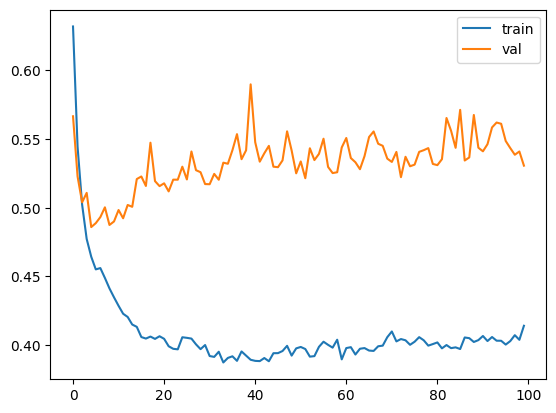

In [21]:
### 손실곡선
plt.plot(history.epoch, history.history["loss"])
plt.plot(history.epoch, history.history["val_loss"])
plt.legend(["train", "val"])
plt.show()

#### GRU 계층 사용하기
- GRU(Gated Recurrent Unit, 게이트 반복 단위)모델
    - LSTM의 4단계 게이트를 3단계로 줄여서 속도를 향상시킨 모델
    - 성능은 LSTM과 유사함

In [24]:
### 모델 생성하기
model = keras.Sequential()

### 입력계층 (임베딩 계층) 추가하기
model.add(
    keras.layers.Embedding(input_dim=500, output_dim=16, input_length=100)
)

### 은닉계층 (LSTM 계층) 추가하기 : RNN 모델의 이름만 바꿔주면 됨
model.add(
    keras.layers.GRU(units=8)
)

### 출력계층 추가하기
model.add(
    keras.layers.Dense(units=1, activation="sigmoid")
)

### rmsprop 사용, 학습율 0.0001 사용, 정확도 출력
adam = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(
    optimizer=adam,
    loss="binary_crossentropy",
    metrics="accuracy"
)

### 콜백함수 정의
mcp_cb = keras.callbacks.ModelCheckpoint(
    "./model/best_GRU_model.h5",
    save_best_only=True
)
es_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

### 모델 훈련시키기
history = model.fit(
    train_seq, train_target, epochs=100, batch_size=64,
    validation_data=(val_seq, val_target),
    callbacks=[mcp_cb, es_cb]
)

Epoch 1/100
313/313 [==============================] - 4s 9ms/step - loss: 0.6014 - accuracy: 0.6643 - val_loss: 0.5130 - val_accuracy: 0.7454
Epoch 2/100
313/313 [==============================] - 2s 7ms/step - loss: 0.4833 - accuracy: 0.7630 - val_loss: 0.4918 - val_accuracy: 0.7596
Epoch 3/100
313/313 [==============================] - 2s 7ms/step - loss: 0.4667 - accuracy: 0.7778 - val_loss: 0.4812 - val_accuracy: 0.7686
Epoch 4/100
313/313 [==============================] - 2s 8ms/step - loss: 0.4539 - accuracy: 0.7796 - val_loss: 0.4902 - val_accuracy: 0.7620
Epoch 5/100
313/313 [==============================] - 2s 7ms/step - loss: 0.4405 - accuracy: 0.7883 - val_loss: 0.4735 - val_accuracy: 0.7764
Epoch 6/100
313/313 [==============================] - 2s 7ms/step - loss: 0.4294 - accuracy: 0.7952 - val_loss: 0.4778 - val_accuracy: 0.7724
Epoch 7/100
313/313 [==============================] - 2s 7ms/step - loss: 0.4204 - accuracy: 0.8033 - val_loss: 0.4758 - val_accuracy: 0.7710

In [25]:
### 최적의 모델 읽어들여서, 훈련/검증/테스트 데이터로 성능검증하기
best_model = keras.models.load_model("./model/best_GRU_model.h5")

best_model.evaluate(train_seq, train_target)
best_model.evaluate(val_seq, val_target)
best_model.evaluate(test_seq, test_target)

### 배치사이즈 32
# 625/625 [==============================] - 2s 3ms/step - loss: 0.4153 - accuracy: 0.8072
# 157/157 [==============================] - 1s 3ms/step - loss: 0.4715 - accuracy: 0.7682
# 782/782 [==============================] - 3s 3ms/step - loss: 0.4563 - accuracy: 0.7804

### 배치사이즈 64
# 625/625 [==============================] - 2s 3ms/step - loss: 0.4099 - accuracy: 0.8061
# 157/157 [==============================] - 1s 3ms/step - loss: 0.4735 - accuracy: 0.7764
# 782/782 [==============================] - 2s 3ms/step - loss: 0.4582 - accuracy: 0.7791

782/782 [==============================] - 2s 3ms/step - loss: 0.4582 - accuracy: 0.7791


[0.4582064747810364, 0.7790799736976624]

<GRU Param 계산공식>
 - GRU Param = 가중치 갯수 * (출력갯수 * (입력갯수 + 출력갯수 + 1))
             = 3          *     (8   *    (16    +   8     + 1))
             =
             
<가중치 설명>
 * 새로운 기억 셀(LSTM에서의 셀상태)
  - 현재 시점의 입력과 업데이트된 이전 상태를 바탕으로 생성된 정보를 저장하는 역할
 
 * 업데이트 게이트
  - 이전의 정보를 얼마나 유지할지 결정
  - 문장의 앞부분에서 중요한 정보가 포함되어 있다면,
    업데이트 게이트는 이 정보를 유지하도록(새로운 기억셀 업데이트) 처리하는 역할 수행
 
 * 리셋 게이트
  - 이전의 정보를 얼마나 무시할지 결정
  - 문장 중간에 나온 덜 중요한 정보는 무시할 수 있도록 처리하는 역할 수행
 
 * 중요한지 또는 무시할지는 단어들의 발생 빈도를 통해서 스스로 결정함
